In [2]:
import torch 
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline 

# Automatic Relevance Determination

We consider the general setting of the type-2 likelihood optimisation. Hence, we rely on the variational inference framework. In more restrictive cases, like linear models, derivations are closed form and more effective optimization routine avaliable ([example](https://github.com/evgenii-egorov/sk-bdl/blob/main/seminar_2/notebook/RVMReg-Solutions.ipynb)).

Let's introduce heroes of our equations:
+ A training dataset of target variables $y_n$ and features $x_n$ for each object $n$, that we observe: $$D=\{x_n,y_n\}_{n=1}^{N}.$$ 
+ A likelihood or our model assumptions on the distribution of the target, given hidden parameters $w$. 
Note that here we assume conditional independence between differen objects given $w$: $$p(D|w) = \prod_{n=1}^{N}p(y_n|x_n, w).$$
+ A prior distribution over hidden parameters $w$ $$p(w|\tau).$$ 

The type-2 likelihood optimisation is the following routine:
$$
\tau^{*} = \arg\max\limits_{\tau} \log p(D|\tau)= \arg\max\limits_{\tau}\log\int_{\text{supp}(p)}p(w) p(D|w)\,dw.
$$

For arbitary pair of the likelihood and prior the integral is intractable. Hence, we introduce optimisation over variational lower bound:
$$
\tau^{*} = \arg\max\limits_{\tau}\log p(D|\tau)= \arg\max\limits_{\tau, q(w)}\,\int_{\text{supp}(q)} q(w)\log p(D|w)\,dw - \text{KL}[q(w);p(w|\tau)],\\
\text{KL}[q(w);p(w|\tau)] = -\text{H}[q]-\int_{\text{supp}(q)} q(w)\log p(w|\tau)\,dw.
$$

At this point we need to introduce approximation to get further:
1. Parametrize $p(w|\tau), p(y_n|x_n, w)$ and $q(w|\phi)$ with suitable densities.
2. Relax optimization in coordinate-wise manner: find optimal $\tau$ for any $q(w|\phi)$ as a function $\tau(\phi)$ and then optimize variational lower bound with respect to the $\phi$.

Let's start with the parametrisation. We have quite a freedom. However, we need to align parametrisation with our goals. We start from the assumption that the complixity flexiability of the model $p(y_n|x_n, w)$ depends from the number of non-zero $w$. Then a possible prior distirbution to reflect this is following:
$$
p(w|\tau)=\prod\limits_{d=1}^{D}\mathcal{N}(w_d|0,\tau_d^{-1}), w_d\in\mathbb{R},
$$
where $d\in\{1,\dots,D\}$ is suitable indexing, i.e. we flatten $w$. Than for variational distribution we can select the same parametrization family:
$$
q(w|\phi)=\prod\limits_{d=1}^{D}\mathcal{N}(w_d|\mu_d,\sigma_d^2), w_d\in\mathbb{R}.
$$

Aimed with this let's go to the step 2.

$$
\max\limits_{\phi}\max\limits_{\tau(\phi)}\,\int_{\text{supp}(q)} q(w)\log p(D|w)\,dw - \text{KL}[q(w);p(w|\tau)] = \max\limits_{\phi}\,\int_{\text{supp}(q)} q(w|\phi)\log p(D|w)\,dw + \max\limits_{\tau(\phi)} - \text{KL}[q(w|\phi);p(w|\tau)]. 
$$

Let's solve internal loop:

$$
\max\limits_{\tau(\phi)}- \text{KL}[q(w|\phi);p(w|\tau)] = \min\limits_{\tau(\mu,\sigma)}\sum\limits_{d=1}^{D}\text{KL}\left[\mathcal{N}(w_d|\mu_d,\sigma_d^2);\mathcal{N}(w_d|0,\tau_d^{-1})\right].
$$
By first-order condition:
$$
\tau^{*}(\mu,\sigma)_d = \left(\mu_d^2 + \sigma^2_d \right)^{-1}.
$$
Substitute back, we obtain:
$$
\phi^{*} = \arg\max\limits_{\phi}\max\limits_{\tau(\phi)}\,\int_{\text{supp}(q)} q(w)\log p(D|w)\,dw - \text{KL}[q(w);p(w|\tau)] =  \\ 
= \arg\max\limits_{\phi}\,\int_{\text{supp}(q)} q(w|\phi)\log p(D|w)\,dw -\sum\limits_{d=1}^{D}\log\left(1+\dfrac{\mu_d^2}{\sigma^2_d}\right). 
$$

We can also re-write in following parametrisation:
$$
\alpha_d = \left(\dfrac{\sigma_d^2}{\mu^2_d}\right), \mathcal{N}(w_d|\mu_d,\sigma_d^2) = \mathcal{N}(w_d|\mu_d,\mu_d^2\alpha_d).
$$

In [3]:
class LinearStoch(nn.Module):
    def __init__(self, d_in, d_out):
        super(LinearStoch, self).__init__()
        self.d_in = d_in
        self.d_out = d_out
        
        self.W = nn.Parameter(torch.Tensor(d_out, d_in))
        self.log_std = nn.Parameter(torch.Tensor(d_out, d_in))
        self.bias = nn.Parameter(torch.Tensor(1, d_out))
        
        self.init_params(std=1e-2)
        
    def init_params(self, std):
        self.bias.data.zero_()
        self.W.data.normal_(0, std)
        self.log_std.data.fill_(-3)
        
    def get_mask(self, alpha_th=3):
        log_alpha = -2. * torch.log(torch.abs(self.W) - self.log_std + 1e-6)
        mask = (log_alpha < alpha_th).float()
        return log_alpha, mask
    
    def kl_term(self):
        log_alpha, mask = self.get_mask()
        log_alpha = torch.clamp(log_alpha, -5,5)
        return torch.sum(torch.log(1+torch.exp(-log_alpha)))
        
    def forward(self, x, non_stoch=False):
        train = self.training 
        
        if non_stoch:
            stoch_part = 0.
            activation_mean = F.linear(x, self.W) + self.bias
            return activation_mean
        
        if train:
            activation_var = F.linear(x * x, torch.exp(self.log_std * 2.))
            activation_mean = F.linear(x, self.W) + self.bias
            stoch_part = torch.sqrt(activation_var + 1e-6) * torch.randn_like(activation_mean)
        else:
            stoch_part = 0.
            log_alpha, mask = self.get_mask()
            activation_mean = F.linear(x, self.W * mask) + self.bias
            
        return activation_mean + stoch_part
    
class ResF(nn.Module):
    def __init__(self, F):
        super(ResF, self).__init__()
        self.F = F
        
    def forward(self, x):
        return x + self.F(x)
    
    
class ARD(nn.Module):
    def __init__(self, net, train_size):
        super(ARD, self).__init__()
        self.train_size = train_size
        self.net = net

    def forward(self, input, target, kl_weight=1.0):
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_term'):
                kl = kl + module.kl_term()
        return F.mse_loss(input, target, reduction='mean') * self.train_size + kl_weight * kl

In [4]:
def make_net():
    d_in = 1
    d_out = 1
    h = 150
    depth_r = 0
    depth_nr = 3

    net = nn.Sequential(
        LinearStoch(d_in, h),
        nn.Tanh(),

        *[ResF(
            nn.Sequential(LinearStoch(h, h), nn.Tanh())
            ) for d in range(depth_r)],

        *[nn.Sequential(LinearStoch(h, h), nn.Tanh())
             for d in range(depth_nr)],
        LinearStoch(h, d_out)
    )
    return net

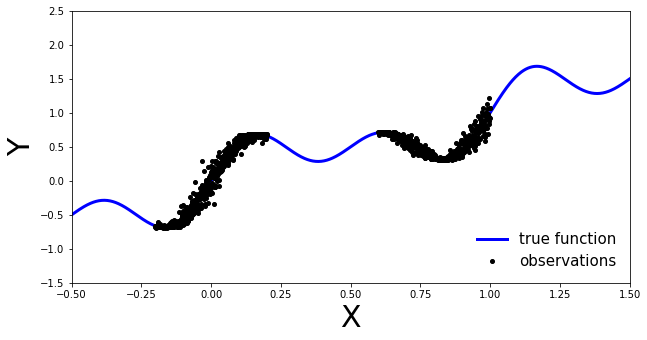

In [5]:
# set Numpy seed
np.random.seed(42)

x = np.linspace(-.2, 0.2, 500)
x = np.hstack([x, np.linspace(.6, 1, 500)])
ε = 0.02 * np.random.randn(x.shape[0])
y = x + 0.3 * np.sin(2 * np.pi * (x + ε)) + 0.3 * np.sin(4 * np.pi * (x + ε)) + ε

x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true) 

xlims = [-.5, 1.5]
ylims = [-1.5, 2.5]

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

plt.legend(loc=4, fontsize=15, frameon=False);

In [6]:
N = x.shape[0]
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()

x_true = torch.from_numpy(x_true).float()
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=128, shuffle=True)
net = make_net()

In [7]:
def train(epochs, kl_weight, N):
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    ard_loss = ARD(net, N).cuda()
    for epoch in range(1, epochs + 1):
        net.train()
        train_loss, train_mse = 0, 0 
        for batch_idx, (data, target) in enumerate(train_loader):
            x = data.cuda().unsqueeze(-1)
            y = target.cuda()
            optimizer.zero_grad()

            output = net(x).flatten()

            loss = ard_loss(output, y, kl_weight)
            loss.backward()
            optimizer.step()


            train_loss += loss.item() 
            train_mse += torch.sum((y - output) ** 2).item()

        if epoch % 100 == 0:
            print((train_loss-train_mse) / N, train_mse / N)

Here we train stochasticly, but without $KL$ term:

In [8]:
train(900, 0, N)

0.19490519618988036 0.027923501014709473
0.15062430381774902 0.02155497360229492
0.14510497891902924 0.020840392708778382
0.14468977999687194 0.020611907243728637
0.13986359798908235 0.02003625285625458
0.14286921644210815 0.020347567081451415
0.13070427715778352 0.018659038424491882
0.07695438778400421 0.011013311266899108
0.06117963838577271 0.008794287204742431


In [10]:
def plot():
    xlims = [-.5, 1.5]
    ylims = [-1.5, 2.5]

    K = 4
    fig, ax = plt.subplots(1, K, figsize=(25, 5))
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_xlabel("X", fontsize=30)
    ax[0].set_ylabel("Y", fontsize=30)

    ax[0].plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax[0].plot(x, y, 'ko', markersize=4, label="observations")

    ax[0].legend(loc=4, fontsize=15, frameon=False);
    net.eval()
    ax[0].plot(x_true, net(x_true.cuda().unsqueeze(-1)).flatten().cpu().detach(), color='red', label='prediction');
    ax[0].grid(True)
    
    with torch.no_grad():
        ax[1].imshow(torch.abs(net[0].W.cpu()))
        ax[1].axis('off')
        ax[1].set_title('weights')
        
        for i in (2,3):
            _, mask = net[i][0].get_mask()
            ax[i].imshow(torch.abs(net[i][0].W.cpu() * mask.cpu()))
            ax[i].axis('off')
            ax[i].set_title('weights')

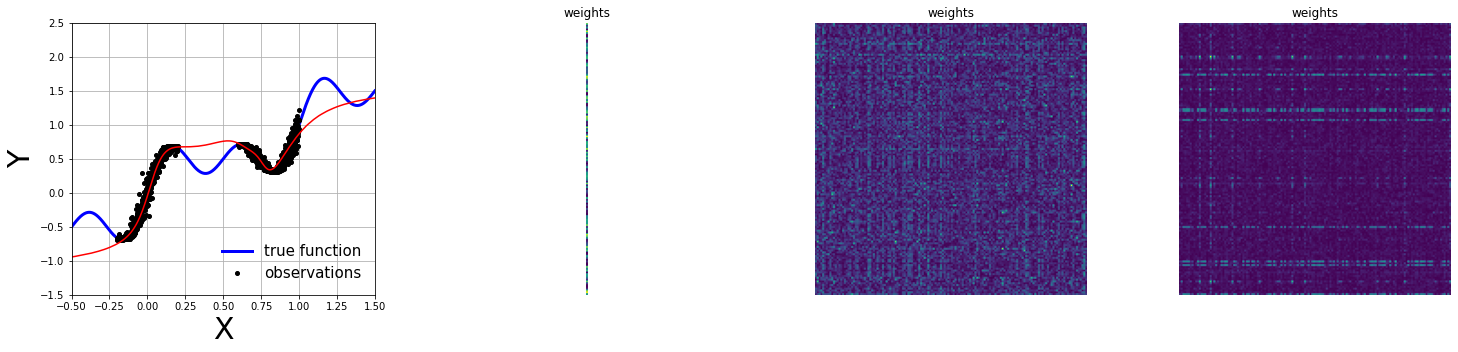

In [11]:
plot()

Let's add $KL$ with weight $1$:

In [12]:
train(900, 1, N)

6.314743453025818 0.011547867774963378
5.082797283411026 0.016617328405380247
3.4232353985309603 0.02134586977958679
1.8166304066181183 0.023919474363327028
0.7998428716659546 0.02435154056549072
0.45261868023872376 0.023580275297164915
0.3591026906967163 0.022360817909240722
0.3391612677574158 0.02322131586074829
0.3247805449962616 0.022878638505935668


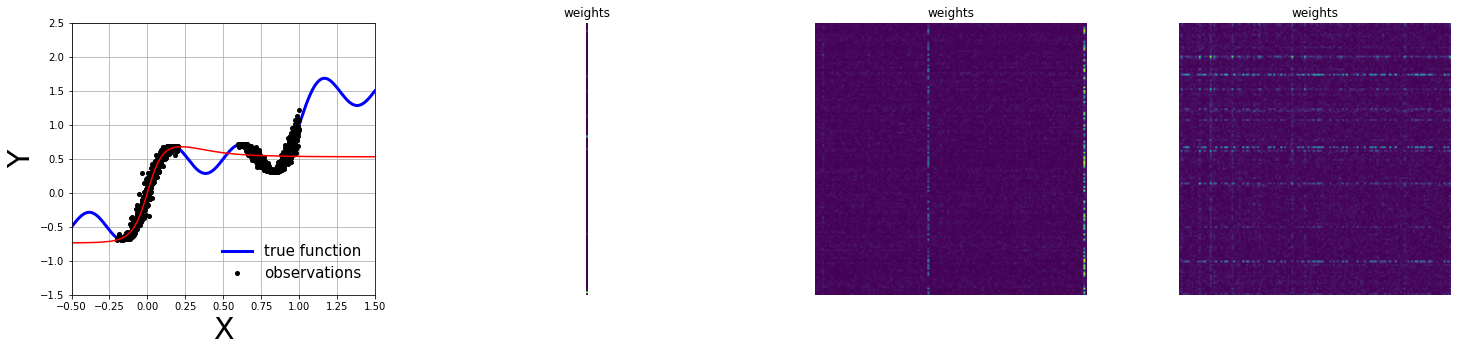

In [13]:
plot()

Let's do something in between:

In [16]:
net = make_net().cuda()
train(900, 0, N)
train(100, 0.1, N)

0.17521137952804566 0.02517607355117798
0.14980901622772216 0.021475470542907715
0.14497028255462646 0.02068660831451416
0.14054118847846986 0.020017454862594604
0.1403751609325409 0.019881837129592895
0.14548839294910432 0.02070589244365692
0.1319307324886322 0.01883234143257141
0.10470537507534027 0.014937390923500061
0.07095859086513519 0.010142474770545959
0.7025697215795517 0.010486629128456116


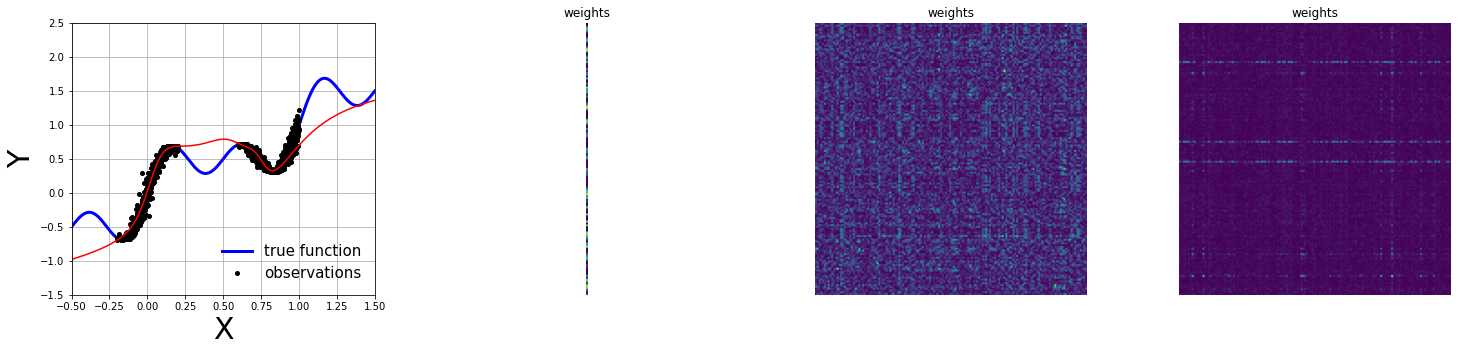

In [17]:
plot()